In [138]:
import json
import tensorflow as tf

In [139]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Hyperparameters

We placed the hyperparameters in the cell below so you can easily tweak it later:

In [140]:
datastore=[]

with open("sarcasm.json", 'r') as f:
    for line in f:
        datastore.append(json.loads(line))

In [141]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

## 

This is an extension of the week2 lab from the Coursera Course Natural Language Processing in Tensorflow. There was a section in the week's tutorials which demonstrated how model loss changed as you varied the embedding_layers, vocab_size etc. which was used for tokenization and model generation. I decided to split out the separate sections related to creating the model into methods so that I could try this.

## Hyperparameters

In [142]:
class HyperParam:

    def __init__(self, name:str, vocab_size:int, max_length:int, output_dim:int, training_weight:float):
        self._name=name
        self._vocab_size=vocab_size
        self._max_length=max_length
        self._output_dim=output_dim
        self._trunc_type='post'
        self._padding_type='post'
        self._oov_tok="<OOV>"
    

    def __str__(self):
        return f"name: {self._name}, vocab_size: {self._vocab_size}, max_length: {self._max_length}, output_dim: {self._output_dim}"

## Data Splitting / Model Definition Methods

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def get_tokenizer(train_tokens : list[str], hyper_param : HyperParam)
    tokenizer = Tokenizer(num_words=hyper_param._vocab_size, oov_token=hyper_param._oov_tok)
    tokenizer.fit_on_texts(train_tokens)
    return tokenizer


def get_testing_and_training_split(tokens : list[str], labels : list[int], training_weight : float):

    training_size = int(len(tokens) * training_weight)
    training_sentences = tokens[0:training_size]
    testing_sentences = tokens[training_size:]

    training_labels = labels[0:training_size]
    testing_labels = labels[training_size:]

    return training_sentences, training_labels, testing_sentences, testing_labels


def get_testing_and_training_sequences(training_sentences : list[str], testing_sentences : list[str], tokenizer : Tokenizer, hyper_param : HyperParam):
    
    training_sequences = tokenizer.texts_to_sequences(training_sentences)
    padded_training_sequences = pad_sequences(training_sequences, maxlen=hyper_param._max_length, 
        padding=hyper_param._padding_type, truncating=hyper_param._trunc_type)

    testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
    padded_testing_sequences = pad_sequences(testing_sequences, maxlen=hyper_param._max_length, 
        padding=hyper_param._padding_type, truncating=hyper_param._trunc_type)

    return padded_training_sequences, padded_testing_sequences

In [144]:
def get_model(vocab_size : int, input_length : int, output_dim:int):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [145]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, name : str, loss_type : str):
  plt.plot(history.history[loss_type])
  plt.plot(history.history['val_'+loss_type])
  plt.xlabel("Epochs")
  plt.title(name)
  plt.legend([loss_type, 'val_'+loss_type])
  plt.show()

## Generate Model History

In [146]:
hyper_params=[]

In [147]:
actual_max_len = max(len(s) for s in sentences for w in s.split(' '))
actual_vocab_size = len(set([s for s in sentences for w in s.split(' ')]))

In [148]:
print(f"actual_max_len {actual_max_len}, actual_vocab_size {actual_vocab_size}")

actual_max_len 254, actual_vocab_size 26602


In [149]:
hyper_params.append(HyperParam(name="model 1", vocab_size=1000, max_length=32, output_dim=10))
hyper_params.append(HyperParam(name="model 2", vocab_size=actual_vocab_size, max_length=actual_max_len, output_dim=10))

#hyper_params.append(HyperParam(name="model 2", vocab_size=10000, embedding_dim=32, max_length=16, training_size=20000))
#hyper_params.append(HyperParam(name="model 3", vocab_size=1000, embedding_dim=16, max_length=16, training_size=20000))
#hyper_params.append(HyperParam(name="model 4", vocab_size=actual_vocab_size, embedding_dim=actual_embedding_dim, max_length=actual_max_len, training_size=20000))

In [150]:
print(hyper_params[0])

name: model 1, vocab_size: 1000, max_length: 32, output_dim: 10


In [159]:
history=[]

In [160]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def compile_and_train_model(
    training_sentences : list[str],
    testing_sentences : list[str],
    training_labels : list[str],
    testing_labels : list[str],
    tokenizer : Tokenizer,
    hyper_param : HyperParam,
    num_epochs : int):

    padded_training_sequences, padded_testing_sequences=get_testing_and_training_sequences(
        tokenizer=tokenizer, 
        training_sentences=training_sentences, 
        testing_sentences=testing_sentences, 
        hyper_param=hyper_param)
    
    training_labels = np.array(training_labels)
    testing_labels = np.array(testing_labels)
    model = get_model(vocab_size=hyper_param._vocab_size, output_dim=hyper_param._output_dim, 
        input_length=hyper_param._max_length)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, verbose=1, mode='max',
                               restore_best_weights=False)
    callbacks=[early_stopping]

    # Train the model
    return model.fit(
        padded_training_sequences, 
        training_labels, 
        epochs=num_epochs, 
        validation_data=(padded_testing_sequences, testing_labels),
        callbacks=callbacks,
        verbose=2)

Running all of the models and storing history.

In [161]:
num_epochs = 30

tokenizer = get_tokenizer()
training_sentences, training_labels, testing_sentences, testing_labels=get_testing_and_training_split(
        tokens=sentences, labels=labels, hyper_param=hyper_param)

for param in hyper_params:
    h = compile_and_train_model(
        training_sentences=training_sentences,
        testing_sentences=testing_sentences,
        training_labels=training_labels,
        testing_labels=testing_labels,
        tokenizer=tokenizer, 
        hyper_param=param, 
        num_epochs=num_epochs)
    history.append(h)

Epoch 1/30
668/668 - 6s - loss: 0.5839 - accuracy: 0.6798 - val_loss: 0.4438 - val_accuracy: 0.7928 - 6s/epoch - 9ms/step
Epoch 2/30
668/668 - 4s - loss: 0.4047 - accuracy: 0.8166 - val_loss: 0.4050 - val_accuracy: 0.8100 - 4s/epoch - 6ms/step
Epoch 3/30
668/668 - 4s - loss: 0.3748 - accuracy: 0.8295 - val_loss: 0.4008 - val_accuracy: 0.8145 - 4s/epoch - 7ms/step
Epoch 4/30
668/668 - 3s - loss: 0.3659 - accuracy: 0.8356 - val_loss: 0.3985 - val_accuracy: 0.8173 - 3s/epoch - 5ms/step
Epoch 5/30
668/668 - 3s - loss: 0.3594 - accuracy: 0.8375 - val_loss: 0.4017 - val_accuracy: 0.8141 - 3s/epoch - 5ms/step
Epoch 6/30
668/668 - 4s - loss: 0.3563 - accuracy: 0.8396 - val_loss: 0.4040 - val_accuracy: 0.8122 - 4s/epoch - 6ms/step
Epoch 6: early stopping
Epoch 1/30
710/710 - 10s - loss: 0.6846 - accuracy: 0.5593 - val_loss: 0.6767 - val_accuracy: 0.5708 - 10s/epoch - 14ms/step
Epoch 2/30
710/710 - 7s - loss: 0.6146 - accuracy: 0.6710 - val_loss: 0.4946 - val_accuracy: 0.7951 - 7s/epoch - 10ms/s

name: model 1, vocab_size: 1000, max_length: 32, output_dim: 10


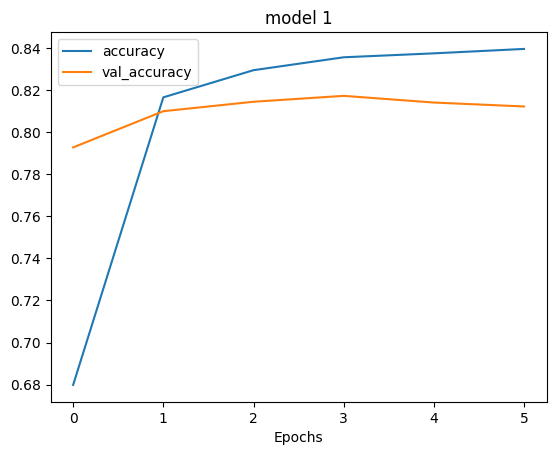

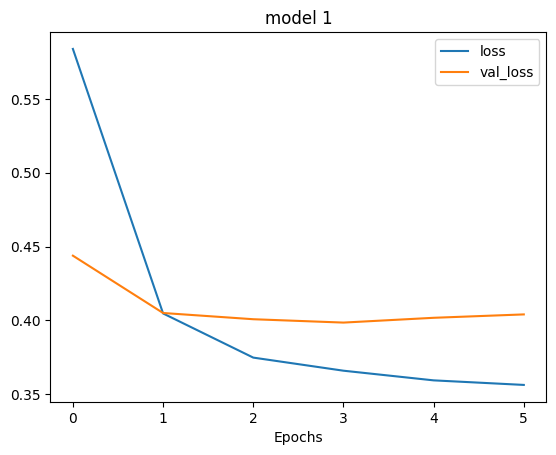

name: model 2, vocab_size: 26602, max_length: 254, output_dim: 10


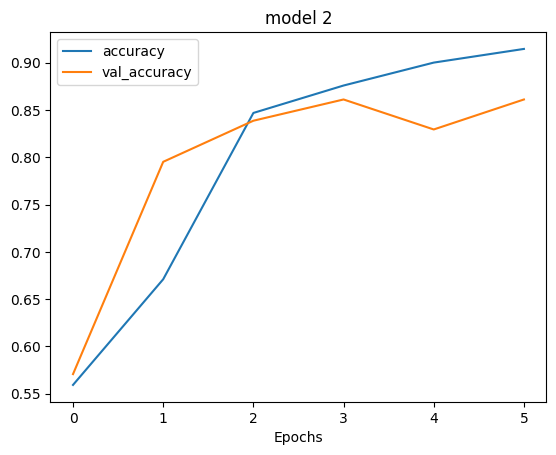

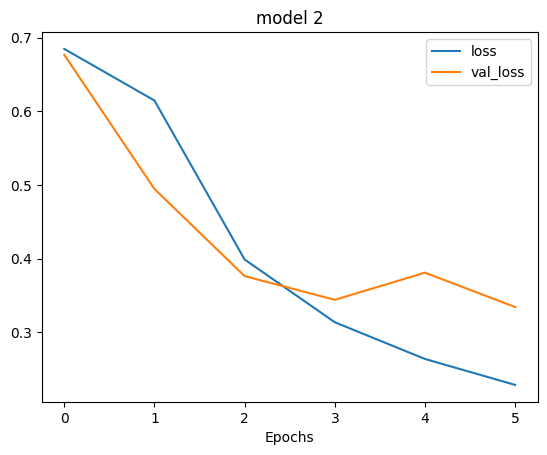

In [162]:
for i, param in enumerate(hyper_params):
    print(param)
    h = history[i]
    plot_graphs(h, param._name, "accuracy")
    plot_graphs(h, param._name, "loss")

In [ ]:
predictions = [
    "I hated this film. Its the worst thing I have ever seen."
]